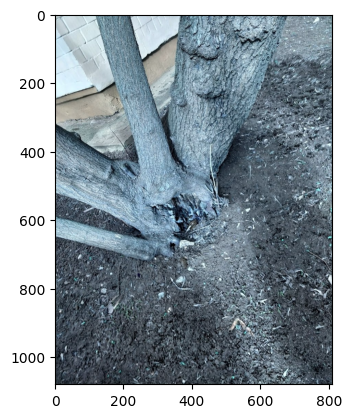

In [14]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Загрузка изображения ---
image = cv2.imread("ing_test/photo_5384555870446286053_y.jpg")
plt.imshow(image)

In [16]:
from TreeDetection import TreeDetector

detector = TreeDetector()

boxes, classes = detector.bboxes(image)
detector.visualize_boxes(image, boxes, classes)


0: 640x480 1 tree, 22.2ms
Speed: 18.2ms preprocess, 22.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


array([[[193, 201, 201],
        [192, 201, 201],
        [191, 201, 201],
        ...,
        [129, 140, 148],
        [139, 149, 157],
        [130, 139, 148]],

       [[192, 201, 201],
        [192, 201, 202],
        [191, 200, 202],
        ...,
        [125, 137, 145],
        [123, 135, 143],
        [120, 130, 138]],

       [[192, 202, 202],
        [192, 201, 203],
        [190, 202, 204],
        ...,
        [109, 124, 131],
        [116, 129, 137],
        [118, 131, 139]],

       ...,

       [[ 30,  39,  42],
        [ 30,  39,  42],
        [ 51,  60,  63],
        ...,
        [ 57,  67,  77],
        [ 71,  81,  91],
        [ 73,  81,  91]],

       [[ 28,  37,  38],
        [ 36,  44,  46],
        [ 52,  60,  63],
        ...,
        [ 59,  69,  78],
        [ 78,  87,  97],
        [ 77,  86,  95]],

       [[ 38,  46,  46],
        [ 38,  46,  47],
        [ 42,  49,  52],
        ...,
        [ 56,  67,  75],
        [ 70,  80,  88],
        [ 81,  90,  99]]

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- 1. Загрузка SAM ---
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)
mask_generator = SamAutomaticMaskGenerator(sam)

# --- 2. Загружаем картинку ---
image_np = np.array(image)

# --- 3. Генерация масок ---
masks = mask_generator.generate(image_np)

# Выбираем самую большую маску (обычно это дерево)
mask_areas = [np.sum(m["segmentation"]) for m in masks]
largest_mask_idx = np.argmax(mask_areas)
mask = masks[largest_mask_idx]["segmentation"]

# --- 4. Применяем маску ---
masked_img = image_np.copy()
masked_img[~mask] = 255
masked_pil = Image.fromarray(masked_img)

In [3]:
import json

with open('tree_class.json', 'r') as trees:
    data = json.load(trees)

In [4]:
import open_clip

# --- 1. Загружаем модель BioCLIP ---
model_clip, preprocess, _ = open_clip.create_model_and_transforms(
    'hf-hub:imageomics/bioclip'
)
tokenizer = open_clip.get_tokenizer('hf-hub:imageomics/bioclip')

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip = model_clip.to(device).eval()

# --- 2. Классы (замени на свои) ---
classes = list(data.keys())

# --- 3. Подготовка текстов ---
text_tokens = tokenizer(classes).to(device)

# --- 4. Подготовка изображения ---
image_tensor = preprocess(masked_pil).unsqueeze(0).to(device)

# --- 5. Получение эмбеддингов ---
with torch.no_grad():
    image_features = model_clip.encode_image(image_tensor)
    text_features = model_clip.encode_text(text_tokens)

    # Нормализация
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Сходство
    logits_per_image = 100.0 * image_features @ text_features.T
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()[0]

Silver Birch   : 0.661
Horse Chestnut : 0.047
Small-leaved Lime: 0.000
Norway Maple   : 0.003
Box Elder      : 0.000
Rowan          : 0.133
English Oak    : 0.156

Predicted: Silver Birch


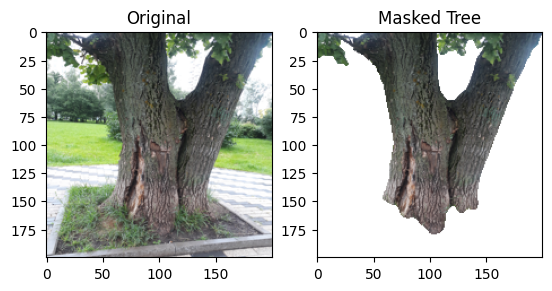

In [5]:
# --- 4. Вывод результата ---
for cls, p in zip(classes, probs):
    print(f"{cls:15s}: {p:.3f}")

print("\nPredicted:", classes[int(probs.argmax())])

# Визуализация
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(masked_pil)
plt.title("Masked Tree")
plt.show()
